In [9]:
import time

import matplotlib.pyplot as plt
import numpy as np

from OOPAO.Atmosphere import Atmosphere
from OOPAO.DeformableMirror import DeformableMirror
from OOPAO.MisRegistration import MisRegistration
from OOPAO.ShackHartmann import ShackHartmann
from OOPAO.Source import Source
from OOPAO.Telescope import Telescope
from OOPAO.Zernike import Zernike
from OOPAO.calibration.CalibrationVault import CalibrationVault
from OOPAO.calibration.InteractionMatrix import InteractionMatrix
from OOPAO.tools.displayTools import cl_plot, displayMap
# %% -----------------------     read parameter file   ----------------------------------
from test_parameter_file_JCBT import initializeParameterFile
import poppy
from astropy.io import fits
#%matplotlib widget

In [10]:
param = initializeParameterFile()


------------ Telescope -------------
Diameter [m]             |   1.30   
Resolution [px]          |    60    
Pixel size [m]           |   0.02   
Surface [m²]             |   1.33   
Central obstruction [%]  |    0     
Pixels in pupil          |   2828   
Field of view [arcsec]   |   0.00   
------------------------------------



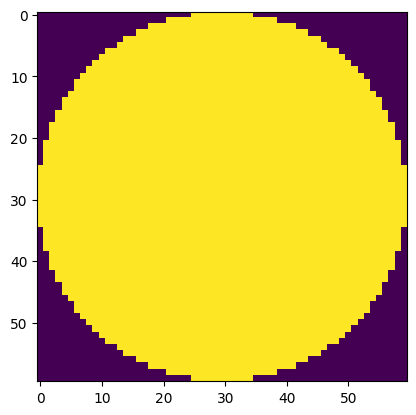

In [11]:
#param = initializeParameterFile()

# %%
#plt.ion()

#%% -----------------------     TELESCOPE   ----------------------------------

# create the Telescope object
#tel = Telescope(resolution          = param['resolution'],\
#                diameter            = param['diameter'],\
#                samplingTime        = param['samplingTime'],\
#                centralObstruction  = param['centralObstruction'],display_optical_path=True)
n_subaperture = param['nSubaperture']

#%% -----------------------     TELESCOPE   ----------------------------------
#from OOPAO.Telescope import Telescope

# create the Telescope object
tel = Telescope(resolution           = param['resolution'],                          # resolution of the telescope in [pix]
                diameter             = param['diameter'],                                        # diameter in [m]        
                samplingTime         = param['samplingTime'],                                   # Sampling time in [s] of the AO loop
                centralObstruction   = param['centralObstruction'],                                      # Central obstruction in [%] of a diameter 
                display_optical_path = False,                                    # Flag to display optical path
                fov                  = 0 )                                     # field of view in [arcsec]. If set to 0 (default) this speeds up the computation of the phase screens but is uncompatible with off-axis targets

#ap = poppy.MultiHexagonAperture(rings=5, flattoflat=1.247)           # 3 rings of 2 m segments yields 14.1 m circumscribed diameter
#sec = poppy.SecondaryObscuration(secondary_radius=0.75)   # secondary with spiders
#atlast = poppy.CompoundAnalyticOptic( opticslist=[ap, sec], name='Mock ATLAST')           # combine into one optic

#plt.figure(figsize=(12,8))
#atlast.display(npix=512, colorbar_orientation='vertical')


#atlast.to_fits(what="amplitude",npix=n_subaperture*n_factor,outname="Temporary.fits")
# Load the FITS file
#pupil = fits.getdata("Temporary.fits").astype(float)
#N = pupil.shape[0]
#print(N)

# Create Telescope object
#tel = Telescope(
#    resolution=n_factor*n_subaperture,
#    diameter=13.7,
#    pupil=pupil,
#    fov=20,
#    centralObstruction=0.1,
#    pupilReflectivity=1,
#    samplingTime=1/1000
#)
#spider_angle = np.linspace(0,360,4,endpoint=False)
#tel.apply_spiders(angle=spider_angle,thickness_spider=0.01)
plt.figure()
plt.imshow(tel.pupil)


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 5.5e-07 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  6.00   
Flux [photon/m²/s]       | 3.6e+07 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------



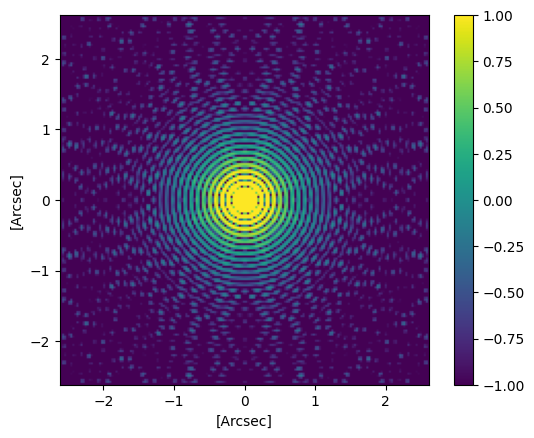


------------- Source --------------
Source                   |   NGS   
Wavelength [m]           | 5.5e-07 
Zenith [arcsec]          |  0.00   
Azimuth [°]              |  0.00   
Altitude [m]             |   inf   
Magnitude                |  4.00   
Flux [photon/m²/s]       | 2.3e+08 
Coordinates [arcsec,deg] | [0,0]
-----------------------------------



In [12]:
#%% -----------------------     NGS   ----------------------------------
# create the Source object
ngs=Source(optBand   = param['NGSband'],                         
           magnitude = param['NGSmagnitude'])

# combine the NGS to the telescope using '*' operator:
ngs*tel

tel.computePSF(zeroPaddingFactor = param["zero_padding_factor"])
plt.figure()
plt.imshow(np.log10(np.abs(tel.PSF)),extent = [tel.xPSF_arcsec[0],tel.xPSF_arcsec[1],tel.xPSF_arcsec[0],tel.xPSF_arcsec[1]])
plt.clim([-1,1])
plt.xlabel('[Arcsec]')
plt.ylabel('[Arcsec]')
plt.colorbar()
plt.show()

src = Source(optBand   = param['scienceBand'],
           magnitude = param['scienceMagnitude'])

# combine the NGS to the telescope using '*' operator:
# src*tel

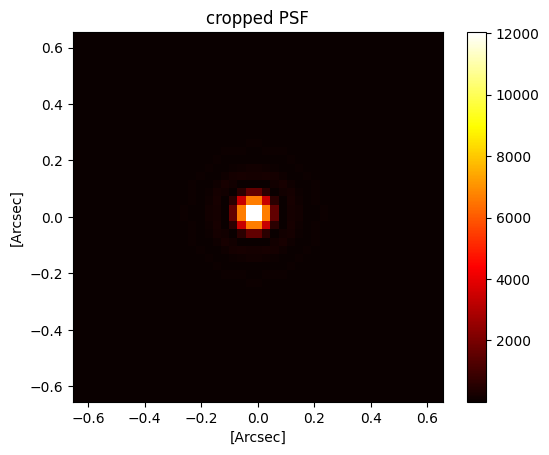

In [13]:
crop_factor= param["PSF_crop_factor"]
def crop_indices(tel_psf,crop_factor):
    if crop_factor <= 0:
        raise ValueError("crop_factor must be > 0")
    
    H, W = tel_psf.shape
    
    out_H = int(round(H / crop_factor))
    out_W = int(round(W / crop_factor))
    
    if out_H <= 0 or out_W <= 0:
        raise ValueError("crop_factor too large")
    
    #True center (works for even & odd sizes)
    cH = (H - 1) / 2
    cW = (W - 1) / 2
    
    # Start indices so that centers coincide
    start_H = int(round(cH - (out_H - 1) / 2))
    start_W = int(round(cW - (out_W - 1) / 2))
    
    end_H = start_H + out_H
    end_W = start_W + out_W
    return (start_H,end_H, start_W,end_W)
crop_indices_1=crop_indices(tel.PSF,crop_factor)
cropped_PSF=tel.PSF.copy()[crop_indices_1[0]:crop_indices_1[1],crop_indices_1[2]:crop_indices_1[3]]
plt.figure()
plt.imshow(cropped_PSF,extent = [tel.xPSF_arcsec[0]/param["PSF_crop_factor"],tel.xPSF_arcsec[1]/param["PSF_crop_factor"]
                                 ,tel.yPSF_arcsec[0]/param["PSF_crop_factor"],tel.yPSF_arcsec[1]/param["PSF_crop_factor"]],
          cmap = "hot")
#plt.imshow(tel.PSF,extent = [tel.xPSF_arcsec[0]/param["PSF_crop_factor"],tel.xPSF_arcsec[1]/param["PSF_crop_factor"],tel.yPSF_arcsec[0]/param["PSF_crop_factor"],tel.yPSF_arcsec[1]/param["PSF_crop_factor"]])

#plt.clim([0,2.0])
plt.title("cropped PSF")
plt.xlabel('[Arcsec]')
plt.ylabel('[Arcsec]')
plt.colorbar()
plt.show()

Creation of layer1/1 ...
-> Computing the initial phase screen...
initial phase screen : 0.001615762710571289 s
ZZt.. : 0.16641807556152344 s
ZXt.. : 0.048954010009765625 s
XXt.. : 0.02519989013671875 s
Done!
Updating the Atmosphere covariance matrices...

------------------------ Atmosphere -------------------------
 Layer | Direction | Speed | Altitude | Frac Cn² | Diameter |
       |    [°]    | [m/s] |   [m]    |   [%]    |   [m]    |
   1   |     0     | 10.0  |  1e+04   |   100    |  1.387   |
r0 @ 500 nm [m] |   0.22   
L0 [m]          |   3.0    
Tau0 [s]        |  0.0068  
V0 [m/s]        |  10.00   
Frequency [Hz]  |  300.0   
-------------------------------------------------------------



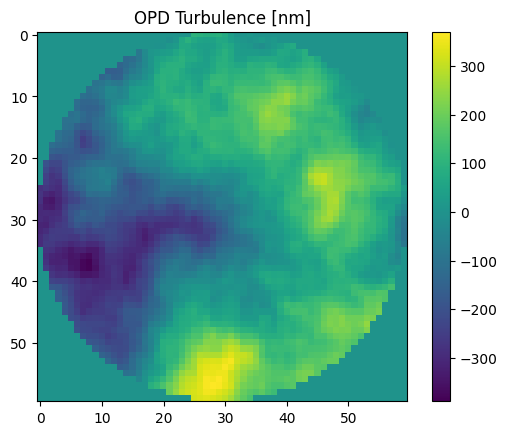

In [14]:
#%% -----------------------     ATMOSPHERE   ----------------------------------

# create the Atmosphere object
atm=Atmosphere(telescope     = tel,\
               r0            = param['r0'],\
               L0            = param['L0'],\
               windSpeed     = param['windSpeed'],\
               fractionalR0  = param['fractionnalR0'],\
               windDirection = param['windDirection'],\
               altitude      = param['altitude'])
# initialize atmosphere
atm.initializeAtmosphere(tel)

atm.update()

plt.figure()
plt.imshow(atm.OPD*1e9)
plt.title('OPD Turbulence [nm]')
plt.colorbar()


In [15]:
ngs*tel 


------------ Telescope -------------
Diameter [m]             |   1.30   
Resolution [px]          |    60    
Pixel size [m]           |   0.02   
Surface [m²]             |   1.33   
Central obstruction [%]  |    0     
Pixels in pupil          |   2828   
Field of view [arcsec]   |   0.00   
Source NGS [m]           | 5.50e-07 
------------------------------------

Telescope and Atmosphere combined!


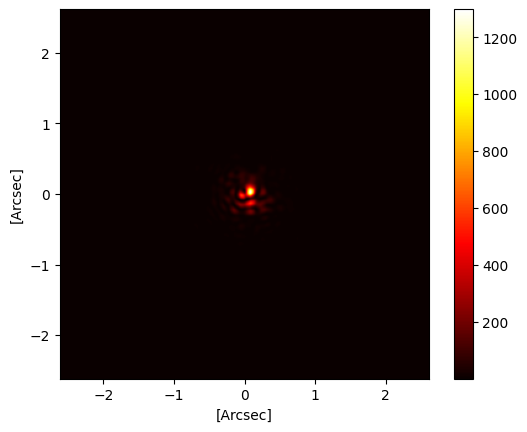

In [16]:

tel+atm
tel.computePSF(5)
plt.figure()
#plt.imshow((np.log10(tel.PSF)),extent = [tel.xPSF_arcsec[0],tel.xPSF_arcsec[1],tel.xPSF_arcsec[0],tel.xPSF_arcsec[1]])
#plt.clim([-1,3])
plt.imshow(tel.PSF,extent = [tel.xPSF_arcsec[0],tel.xPSF_arcsec[1],tel.xPSF_arcsec[0],tel.xPSF_arcsec[1]],cmap="hot")
plt.xlabel('[Arcsec]')
plt.ylabel('[Arcsec]')
plt.colorbar()


No coordinates loaded.. taking the cartesian geometry as a default
Generating a Deformable Mirror: 
Computing the 2D zonal modes...

-------- Deformable mirror --------
Controlled Actuators     |   88    
M4                       |  False  
Pitch [m]                |  0.14   
Mechnical coupling [%]   |   45    
== Misregistration ================
Rotation [°]             |  0.000  
Shift X [m]              |0.000e+00
Shift Y [m]              |0.000e+00
Anamorphosis angle [°]   |  0.000  
Tangential scaling [%]   |  0.000  
Radial scaling [%]       |  0.000  
-----------------------------------



Text(0.5, 1.0, 'DM Actuator Coordinates')

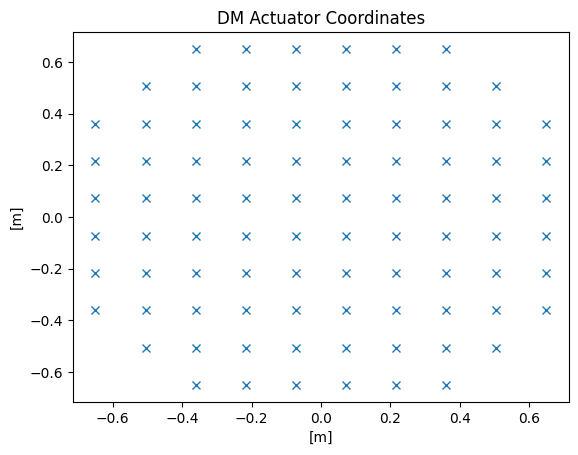

In [17]:
#%% -----------------------     DEFORMABLE MIRROR   ----------------------------------
# mis-registrations object
misReg = MisRegistration()
# if no coordonates specified, create a cartesian dm
dm=DeformableMirror(telescope    = tel,\
                    nSubap       = param['nSubaperture']-1,\
                    mechCoupling = param['mechanicalCoupling'],
                   )

plt.figure()
plt.plot(dm.coordinates[:,0],dm.coordinates[:,1],'x')
plt.xlabel('[m]')
plt.ylabel('[m]')
plt.title('DM Actuator Coordinates')


Telescope and Atmosphere combined!
No user-input pixel scale - using shannon_sampling input value:2 pixel(s) per spot FWHM
-------------Detector--------------
Sensor type              |   CCD   
Resolution [px]          |   60    
Gain                     |    1    
Quantum efficiency [%]   |   100   
Binning                  |   1x1   
Dark current [e-/px/s]   |  0.00   
Photon noise             |  False  
Bkg noise [e-]           |  False  
Readout noise [e-/px]    |   0.0   
-----------------------------------

Valid subapertures selection based on flux considerations
Acquiring reference slopes... Done!
Calibrating the slopes units... Done

------- Shack-Hartmann WFS --------
Subapertures [lenslets]  |   10    
Subaperture Pitch [m]    |  0.13   
Subaperture FoV [arcsec] |  2.62   
Pixel Scale [arcsec]     |  0.436  
Valid Subapertures       |   176   
Spot Sampling [pix]      |  2.00   
Geometric WFS            |  False  
-----------------------------------

Telescope and Atmospher

Text(0.5, 1.0, 'WFS Camera Frame - Without Noise')

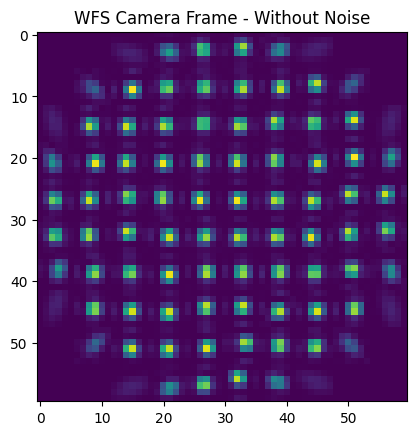

In [18]:
#%% -----------------------     SH WFS   ----------------------------------

# make sure tel and atm are separated to initialize the PWFS
tel+atm
tel.resetOPD()
wfs = ShackHartmann(nSubap          = param['nSubaperture'],\
              telescope             = tel,\
              lightRatio            = param['lightThreshold'],\
              binning_factor=1,\
              is_geometric = False,
              shannon_sampling=True)



#%
wfs.cam.photonNoise = False
tel+atm
ngs*tel*wfs
plt.close('all')
plt.figure()
plt.imshow(wfs.cam.frame)
plt.title('WFS Camera Frame - Without Noise')


In [19]:
# #%% -----------------------     Modal Basis   ----------------------------------
# # compute the modal basis
from OOPAO.calibration.compute_KL_modal_basis import compute_KL_basis
M2C_KL = compute_KL_basis(tel,atm,dm)
#%%
# foldername_M2C  = None  # name of the folder to save the M2C matrix, if None a default name is used 
# filename_M2C    = None  # name of the filename, if None a default name is used 
# # KL Modal basis
# M2C_KL = compute_M2C(telescope            = tel,\
#                                  atmosphere         = atm,\
#                                  deformableMirror   = dm,\
#                                  param              = param,\
#                                  nameFolder         = None,\
#                                  nameFile           = None,\
#                                  remove_piston      = True,\
#                                  HHtName            = None,\
#                                  baseName           = None ,\
#                                  mem_available      = 8.1e9,\
#                                  minimF             = False,\
#                                  nmo                = 300,\
#                                  ortho_spm          = True,\
#                                  SZ                 = np.int(2*tel.OPD.shape[0]),\
#                                  nZer               = 3,\
#                                  NDIVL              = 1)
#
# ao_calib =  ao_calibration(param            = param,\
#                            ngs              = ngs,\
#                            tel              = tel,\
#                            atm              = atm,\
#                            dm               = dm,\
#                            wfs              = wfs,\
#                            nameFolderIntMat = None,\
#                            nameIntMat       = None,\
#                            nameFolderBasis  = None,\
#                            nameBasis        = None,\
#                            nMeasurements    = 100)

# #%% ZERNIKE Polynomials
# # create Zernike Object
# Z = Zernike(tel,300)
# # compute polynomials for given telescope
# Z.computeZernike(tel)

# # mode to command matrix to project Zernike Polynomials on DM
# M2C_zernike = np.linalg.pinv(np.squeeze(dm.modes[tel.pupilLogical,:]))@Z.modes

# # show the first 10 zernikes
# dm.coefs = M2C_zernike[:,:10]
# tel*dm
# displayMap(tel.OPD)



TIME ELAPSED: 0 sec. COMPLETED: 100 %
NMAX =  71
RMS opd error = [[1.17223765e-08 2.14763394e-08 2.14641907e-08]]
RMS Positions = [[7.36588736e-08 3.76220797e-07 3.76258864e-07]]
MAX Positions = [[3.94721818e-07 8.43928572e-07 8.41041125e-07]]
KL WITH DOUBLE DIAGONALISATION: COVARIANCE ERROR =  3.5810604223893096e-15


## Saving the modes

In [23]:
M2C_KL.shape

(101, 84)

In [26]:
from astropy.io import fits as pfits

In [47]:
file_name = f'test_M2C_JCBT_{M2C_KL.shape[0]}_{M2C_KL.shape[1]}'
hdr=pfits.Header()
hdr['TITLE'] = file_name+'_KL'#'M4_KL'
empty_primary = pfits.PrimaryHDU(header=hdr)
## CAREFUL THE CUBE IS SAVED AS A NON SPARSE MATRIX
primary_hdu = pfits.ImageHDU(M2C_KL)
hdu = pfits.HDUList([empty_primary, primary_hdu])
hdu.writeto(file_name+'.fits',overwrite=True)

In [48]:
np.save(file_name, M2C_KL)

In [45]:
M2C_KL.shape

(101, 84)

## Back to simulation

Re-initializing WFS...
Acquiring reference slopes... Done!
Calibrating the slopes units... Done
OOPAO Warning: 
All Detector Noises are disables with the geometric WFS

------- Shack-Hartmann WFS --------
Subapertures [lenslets]  |   10    
Subaperture Pitch [m]    |  0.13   
Subaperture FoV [arcsec] |  2.62   
Pixel Scale [arcsec]     |  0.436  
Valid Subapertures       |   176   
Spot Sampling [pix]      |  2.00   
Geometric WFS            |  True   
-----------------------------------



Text(0, 0.5, 'WFS slopes STD')

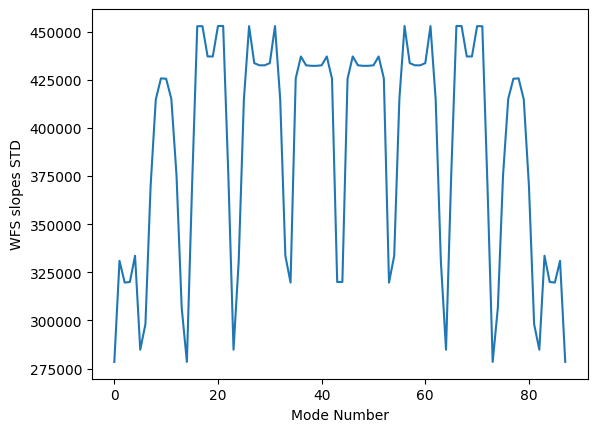

In [20]:
# #%% to manually measure the interaction matrix

# # amplitude of the modes in m
stroke=1e-9
# Modal Interaction Matrix

#%
wfs.is_geometric = True

M2C_zonal = np.eye(dm.nValidAct)
# zonal interaction matrix
calib_zonal = InteractionMatrix(  ngs            = ngs,\
                            atm            = atm,\
                            tel            = tel,\
                            dm             = dm,\
                            wfs            = wfs,\
                            M2C            = M2C_zonal,\
                            stroke         = stroke,\
                            nMeasurements  = 100,\
                            noise          = 'off')

plt.figure()
plt.plot(np.std(calib_zonal.D,axis=0))
plt.xlabel('Mode Number')
plt.ylabel('WFS slopes STD')


Text(0, 0.5, 'WFS slopes STD')

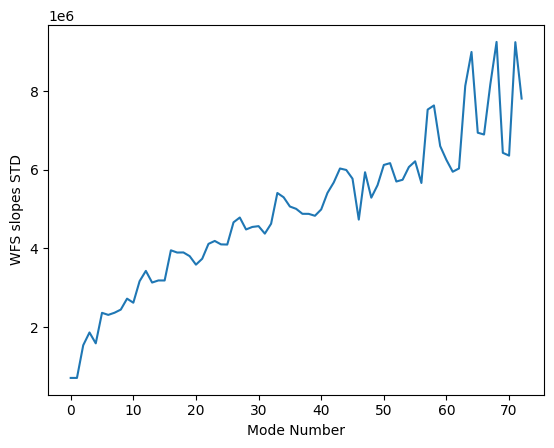

In [21]:
# Modal interaction matrix

# Modal interaction matrix
calib_zernike = CalibrationVault(calib_zonal.D@M2C_KL)

plt.figure()
plt.plot(np.std(calib_zernike.D,axis=0))
plt.xlabel('Mode Number')
plt.ylabel('WFS slopes STD')


In [22]:
#% switch to a diffractive SH-WFS

wfs.is_geometric = False

#%
tel.resetOPD()
# initialize DM commands
dm.coefs=0
ngs*tel*dm*wfs
tel+atm

# dm.coefs[100] = -1

tel.computePSF(4)
plt.close('all')
    
# These are the calibration data used to close the loop
calib_CL    = calib_zernike
M2C_CL      = M2C_KL


# combine telescope with atmosphere
tel+atm

# initialize DM commands
dm.coefs=0
ngs*tel*dm*wfs


plt.show()


Re-initializing WFS...
Acquiring reference slopes... Done!
Calibrating the slopes units... Done

------- Shack-Hartmann WFS --------
Subapertures [lenslets]  |   10    
Subaperture Pitch [m]    |  0.13   
Subaperture FoV [arcsec] |  2.62   
Pixel Scale [arcsec]     |  0.436  
Valid Subapertures       |   176   
Spot Sampling [pix]      |  2.00   
Geometric WFS            |  False  
-----------------------------------

Telescope and Atmosphere combined!
Telescope and Atmosphere combined!


In [23]:
%matplotlib qt

In [24]:
from OOPAO.Detector import Detector

In [25]:
cam = Detector(psf_sampling=3)

-------------Detector--------------
Sensor type              |   CCD   
Gain                     |    1    
Quantum efficiency [%]   |   100   
Binning                  |   1x1   
Dark current [e-/px/s]   |  0.00   
Photon noise             |  False  
Bkg noise [e-]           |  False  
Readout noise [e-/px]    |   0.0   
-----------------------------------



In [26]:
src*tel


------------ Telescope -------------
Diameter [m]             |   1.30   
Resolution [px]          |    60    
Pixel size [m]           |   0.02   
Surface [m²]             |   1.33   
Central obstruction [%]  |    0     
Pixels in pupil          |   2828   
Field of view [arcsec]   |   0.00   
Source NGS [m]           | 5.50e-07 
------------------------------------

In [27]:
# plt.close()
# plt.imshow(tel.OPD)
# plt.colorbar()

In [28]:
nLoop = 1000
zer0_padding = 4
cam = Detector(psf_sampling=zer0_padding)


tel+atm
src*tel*dm*cam
wfsSignal               = np.arange(0,wfs.nSignal)*0
cam.integrationTime = None # if None it will use the AO loop frequency
#cam.readoutNoise = 10
#cam.photonNoise = True
#cam.QE = 0.4
tel.computePSF(zeroPaddingFactor=zer0_padding)
crop_indices_2=crop_indices(tel.PSF,crop_factor)
start_H=crop_indices_2[0]
end_H=crop_indices_2[1]
start_W=crop_indices_2[2]
end_W=crop_indices_2[3]
plt.close('all')
plot_obj = cl_plot(list_fig          = [[np.array(tel.xPSF_arcsec)/zer0_padding,np.array(tel.yPSF_arcsec)/zer0_padding,np.log10(cam.frame)]],\
                   type_fig          = ['imshow'],\
                   list_title        = ['Integration Time: '+str(cam.integrationTime)+' s'],\
                   list_lim          = [[0,1000]],\
                   list_label        = ["arcsec"],\
                   n_subplot         = [1,1],\
                   list_display_axis = [True],\
                   #list_ratio        = [[0.95,0.1],[1,1,1]]
                  ) 
gainCL                  = 0.5
display                 = True

reconstructor = M2C_CL@calib_CL.M
start = time.perf_counter()
for i in range(nLoop):
    a=time.time()
    # update phase screens => overwrite tel.OPD and consequently tel.src.phase
    atm.update()
    # save phase variance
    #total[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
    # save turbulent phase
    turbPhase = tel.src.phase
    # propagate to the WFS with the CL commands applied
    ngs*tel*dm*wfs
    #print(tel.isPaired)
    src*tel*cam
    #print("again"+str(tel.isPaired))
    dm.coefs=dm.coefs-gainCL*np.matmul(reconstructor,wfsSignal)
    # store the slopes after computing the commands => 2 frames delay
    wfsSignal=wfs.signal
    b= time.time()
    #print('Elapsed time: ' + str(b-a) +' s')
    # update displays if required
    if display==True:        
        # tel.computePSF(4)
        # if i>15:
        #     SE_PSF.append(np.log10(tel.PSF))
        #     LE_PSF = np.mean(SE_PSF, axis=0)
        
        cl_plot(list_fig   = [cam.frame[start_H:end_H, start_W:end_W]],
                               plt_obj = plot_obj)
        plt.pause(0.1)
        if plot_obj.keep_going is False:
            break
end = time.perf_counter()    
print(f"Execution time: {end - start:.6f} seconds for {nLoop} number of looops")
    # SR[i]=np.exp(-np.var(tel.src.phase[np.where(tel.pupil==1)]))
    # residual[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
    # OPD=tel.OPD[np.where(tel.pupil>0)]

-------------Detector--------------
Sensor type              |   CCD   
Gain                     |    1    
Quantum efficiency [%]   |   100   
Binning                  |   1x1   
Dark current [e-/px/s]   |  0.00   
Photon noise             |  False  
Bkg noise [e-]           |  False  
Readout noise [e-/px]    |   0.0   
-----------------------------------

Telescope and Atmosphere combined!
Execution time: 12.429978 seconds for 1000 number of looops


In [30]:
nLoop = 1000
# allocate memory to save data
SR                      = np.zeros(nLoop)
total                   = np.zeros(nLoop)
residual                = np.zeros(nLoop)
wfsSignal               = np.arange(0,wfs.nSignal)*0
SE_PSF = []
LE_PSF = tel.PSF
src*tel
zer0_padding=4
tel.computePSF(zeroPaddingFactor=zer0_padding)
crop_indices_2=crop_indices(tel.PSF,crop_factor)
start_H=crop_indices_2[0]
end_H=crop_indices_2[1]
start_W=crop_indices_2[2]
end_W=crop_indices_2[3]
plot_obj = cl_plot(list_fig          = [atm.OPD,tel.mean_removed_OPD,wfs.cam.frame,[dm.coordinates[:,0],np.flip(dm.coordinates[:,1]),dm.coefs],[[0,0],[0,0]],
                                        [np.array(tel.xPSF_arcsec)/param["PSF_crop_factor"],np.array(tel.yPSF_arcsec)/param["PSF_crop_factor"],
                                         np.log10(tel.PSF.copy()[start_H:end_H, start_W:end_W])],
                                        [np.array(tel.xPSF_arcsec)/param["PSF_crop_factor"],np.array(tel.yPSF_arcsec)/param["PSF_crop_factor"],
                                         np.log10(tel.PSF.copy()[start_H:end_H, start_W:end_W])]],\
                   type_fig          = ['imshow','imshow','imshow','scatter','plot','imshow','imshow'],\
                   list_title        = ['Turbulence OPD','Residual OPD','WFS Detector','DM Commands',None,None,None],\
                   list_lim          = [None,None,None,None,None,None,None],\
                   list_label        = [None,None,None,None,['Time','WFE [nm]'],['Short Exposure PSF',''],['Long Exposure_PSF','']],\
                   n_subplot         = [4,2],\
                   list_display_axis = [None,None,None,None,True,True,True],\
                   list_ratio        = [[0.95,0.95,0.1],[1,1,1,1]], s=20)

# loop parameters
gainCL                  = 0.5
display                 = True

reconstructor = M2C_CL@calib_CL.M

for i in range(nLoop):
    a=time.time()
    # update phase screens => overwrite tel.OPD and consequently tel.src.phase
    atm.update()
    # save phase variance
    total[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
    # save turbulent phase
    turbPhase = tel.src.phase
    # propagate to the WFS with the CL commands applied
    ngs*tel*dm*wfs
    src*tel
    dm.coefs=dm.coefs-gainCL*np.matmul(reconstructor,wfsSignal)
    # store the slopes after computing the commands => 2 frames delay
    wfsSignal=wfs.signal
    b= time.time()
    #print('Elapsed time: ' + str(b-a) +' s')
    # update displays if required
    if display==True:        
        tel.computePSF(4)
        if i>15:
            SE_PSF.append(tel.PSF)
            LE_PSF = np.mean(SE_PSF, axis=0)
        
        cl_plot(list_fig   = [atm.OPD,tel.mean_removed_OPD,wfs.cam.frame,
                              dm.coefs,[np.arange(i+1),residual[:i+1]],
                              tel.PSF.copy()[start_H:end_H, start_W:end_W],
                              LE_PSF.copy()[start_H:end_H, start_W:end_W]],
                               plt_obj = plot_obj)
        plt.pause(0.1)
        if plot_obj.keep_going is False:
            break
    
    SR[i]=np.exp(-np.var(tel.src.phase[np.where(tel.pupil==1)]))
    residual[i]=np.std(tel.OPD[np.where(tel.pupil>0)])*1e9
    OPD=tel.OPD[np.where(tel.pupil>0)]
           
    #print('Loop'+str(i)+'/'+str(param['nLoop'])+' Turbulence: '+str(total[i])+' -- Residual:' +str(residual[i])+ '\n')

#%%
plt.figure()
plt.plot(total)
plt.plot(residual)
plt.xlabel('Time')
plt.ylabel('WFE [nm]')

/home/pranavk/Pranav/Projects/git_cloned_repos/OOPAO/OOPAO/tools/displayTools.py:411: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(labelcolor='k')
/home/pranavk/Pranav/Projects/git_cloned_repos/OOPAO/OOPAO/tools/displayTools.py:496: UserWarning: Attempting to set identical low and high xlims makes transformation singular; automatically expanding.
  im_tmp.axes.set_xlim([np.min(data[0])-0.1*np.abs(np.min(data[0])),np.max(data[0])+0.1*np.abs(np.max(data[0]))])
/home/pranavk/Pranav/Projects/git_cloned_repos/OOPAO/OOPAO/tools/displayTools.py:499: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  im_tmp.axes.set_ylim([np.min(data[1])-0.1*np.abs(np.min(data[1])),np.max(data[1])+0.1*np.abs(np.max(data[1]))])


Text(0, 0.5, 'WFE [nm]')

In [24]:
plt.figure()
plt.plot(SR)
plt.title("Strehl Ratio")
plt.show()

In [22]:
np.mean(SR[9:200])

np.float64(0.18642284869550568)